In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf

This notebook is for the Part B of the Assignment where we have to optimize the Neural Network Architecture for segmentation. Firstly I am recreating the U-Net Architecture
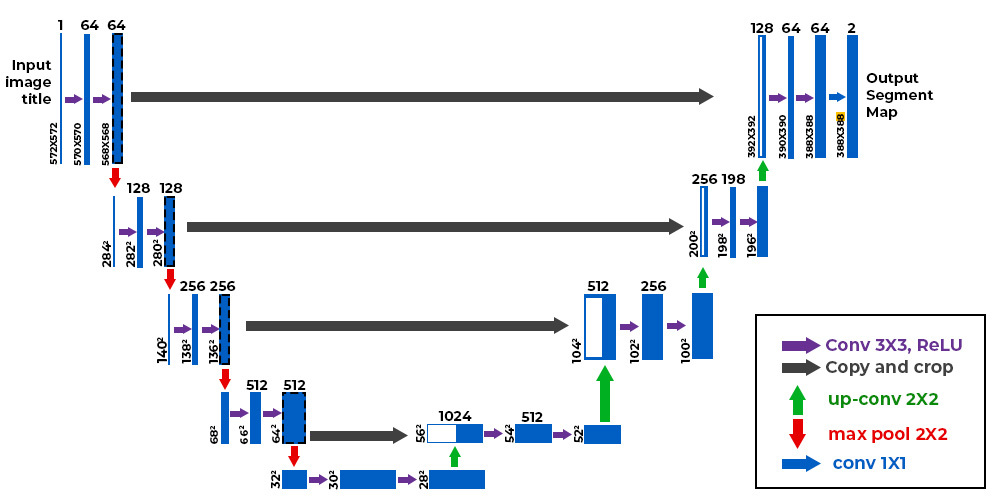

This architecture is essentially the same as the one given in Part A of the assignment

I will start by definining the images height width and channels and then loading the images. The folder contains duplicates so there are also catered for by the script. Finally the data is divided into training and validation sets using train test split

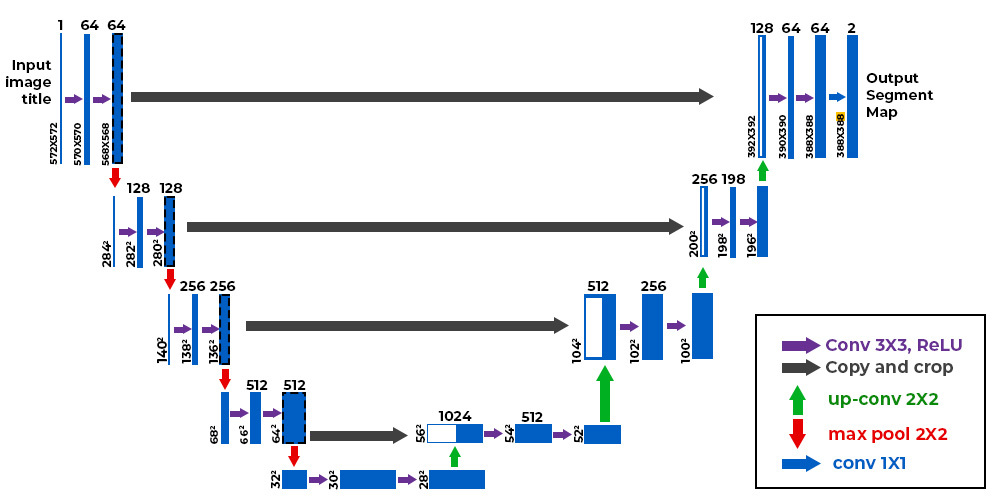

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

x_folder = '/kaggle/input/water-trash-segmentation/5000 Sementic Segmentation/new_x_'
y_folder = '/kaggle/input/water-trash-segmentation/5000 Sementic Segmentation/new_y_'


def load_data(x_folder, y_folder, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    x_files = [f for f in os.listdir(x_folder) if f.endswith('.png') or f.endswith('.jpg')]
    y_files = [f for f in os.listdir(y_folder) if f.endswith('.png') or f.endswith('.jpg')]
    
    y_files = [f for f in y_files if '(' not in f]  # Exclude files with parentheses (like '123(1).png')
    
    x_files = sorted(x_files)
    y_files = sorted(y_files)
    
    if len(x_files) != len(y_files):
        raise ValueError(f"Number of image files ({len(x_files)}) does not match number of mask files ({len(y_files)})")

    x_data = []
    y_data = []

    for i in range(len(x_files)):
        img_path = os.path.join(x_folder, x_files[i])
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        
        mask_path = os.path.join(y_folder, y_files[i])
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="rgb")  # Load as RGB
        mask_array = img_to_array(mask) / 255.0  # Normalize to [0, 1]

        x_data.append(img_array)
        y_data.append(mask_array)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data

x_data, y_data = load_data(x_folder, y_folder)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

x_train shape: (4279, 128, 128, 3), y_train shape: (4279, 128, 128, 3)
x_val shape: (1070, 128, 128, 3), y_val shape: (1070, 128, 128, 3)


In [8]:
Beta=[0.011676873, 0.869083715, 0.119239412]
Beta= np.array(Beta)
# print(Beta)
def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def blance_loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight =Beta
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss *(Beta))

In [9]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=blance_loss, metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_12[0][0]

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

As we can see the model has around **2 million**  trainable parameters which makes it very computationally expensive. I also trained the model for 50 epochs which ended up being much more than neccessary.

In [10]:
# Train the model
history = model.fit(x_train, y_train, 
                    epochs=50,
                    batch_size=16,
                    validation_data=(x_val, y_val))


Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.8399 - loss: 0.0366 - val_accuracy: 0.9873 - val_loss: 0.0201
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9885 - loss: 0.0196 - val_accuracy: 0.9876 - val_loss: 0.0179
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9882 - loss: 0.0176 - val_accuracy: 0.9880 - val_loss: 0.0165
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9881 - loss: 0.0189 - val_accuracy: 0.9875 - val_loss: 0.0165
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9885 - loss: 0.0165 - val_accuracy: 0.9875 - val_loss: 0.0163
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9884 - loss: 0.0163 - val_accuracy: 0.9875 - val_loss: 0.0161
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9887 - loss: 0.0161 - val_accuracy: 0.9873 - val_loss: 0.0161
Epoch 8/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9881 - loss: 0.0161 -

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

Finally to see how the model is performing I am taking random original image its mask and the predicted mask and plotting them using matplotlib

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


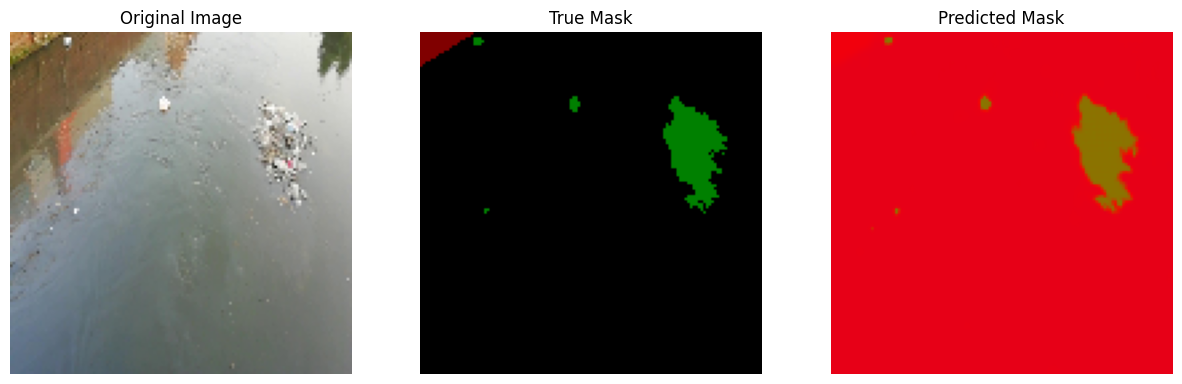

In [11]:
random_idx = random.randint(0, len(x_val) - 1)

image = x_val[random_idx]
true_mask = y_val[random_idx]

predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(true_mask.squeeze(), cmap='gray')
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.show()


As we can see above the model is able to detect the trash and segment the water body and trash into seperate colors.

Next I am going to reduce the number of trainable parameters of the model by halving the number of filters in each layer. That has reduced the number of trainable parameters to under 500,000 which is 1/4th of the original model size. This makes the model much less computationally expensive to train.

In [12]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=blance_loss, metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │        224 │ lambda_2[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128, 128,  │          0 │ conv2d_38[0][0]   │
│ (Dropout)           │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │        584 │ dropout_18[0][0]  │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64, 8) │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │      1,168 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64, 64,    │          0 │ conv2d_40[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │      2,320 │ dropout_19[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │      4,640 │ max_pooling2d_9[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 32, 32,    │          0 │ conv2d_42[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │      9,248 │ dropout_20[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 16, 16,    │          0 │ conv2d_44[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │     36,928 │ dropout_21[0][0]

 Total params: 485,835 (1.85 MB)

 Trainable params: 485,835 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(x_train, y_train, 
                    epochs=10,  
                    batch_size=16,
                    validation_data=(x_val, y_val))

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 96ms/step - accuracy: 0.9498 - loss: 0.0581 - val_accuracy: 0.9873 - val_loss: 0.0225
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9881 - loss: 0.0215 - val_accuracy: 0.9873 - val_loss: 0.0204
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9882 - loss: 0.0198 - val_accuracy: 0.9873 - val_loss: 0.0193
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9878 - loss: 0.0187 - val_accuracy: 0.9873 - val_loss: 0.0179
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9881 - loss: 0.0174 - val_accuracy: 0.9873 - val_loss: 0.0169
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9885 - loss: 0.0168 - val_accuracy: 0.9873 - val_loss: 0.0167
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9880 - loss: 0.0167 - val_accuracy: 0.9873 - val_loss: 0.0164
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9884 - loss: 0.0164 - val_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


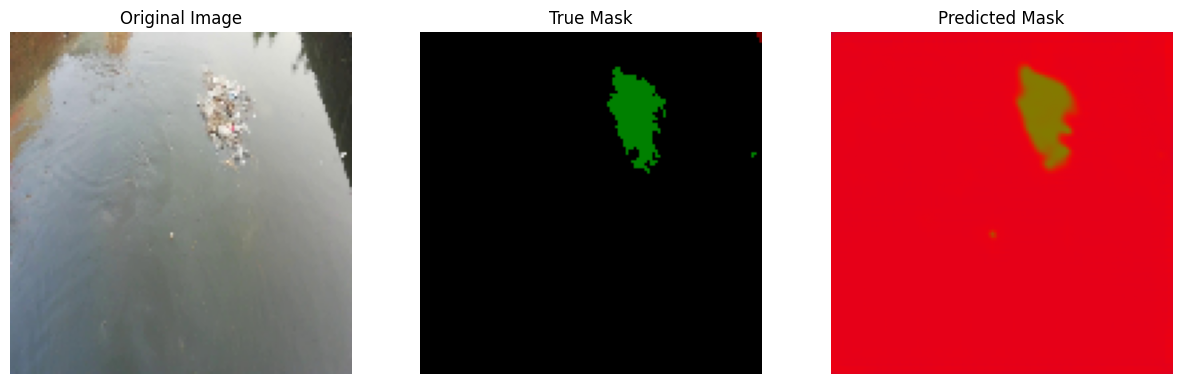

In [17]:
random_idx = random.randint(0, len(x_val) - 1)

image = x_val[random_idx]
true_mask = y_val[random_idx]

predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Expanding dimensions for batch size

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(true_mask.squeeze(), cmap='gray')  # Squeeze mask to remove unnecessary dimension
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask.squeeze(), cmap='gray')  # Squeeze predicted mask
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


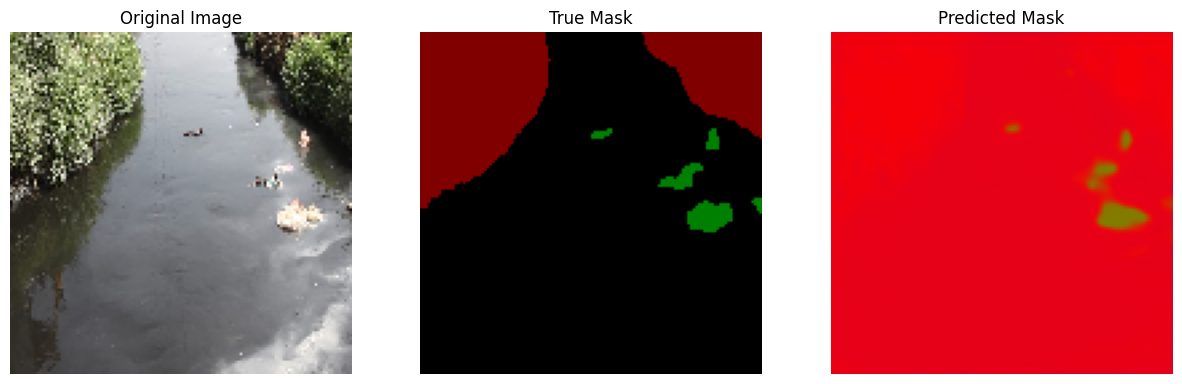

In [18]:
random_idx = random.randint(0, len(x_val) - 1)

image = x_val[random_idx]
true_mask = y_val[random_idx]

predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Expanding dimensions for batch size

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(true_mask.squeeze(), cmap='gray')  # Squeeze mask to remove unnecessary dimension
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask.squeeze(), cmap='gray')  # Squeeze predicted mask
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


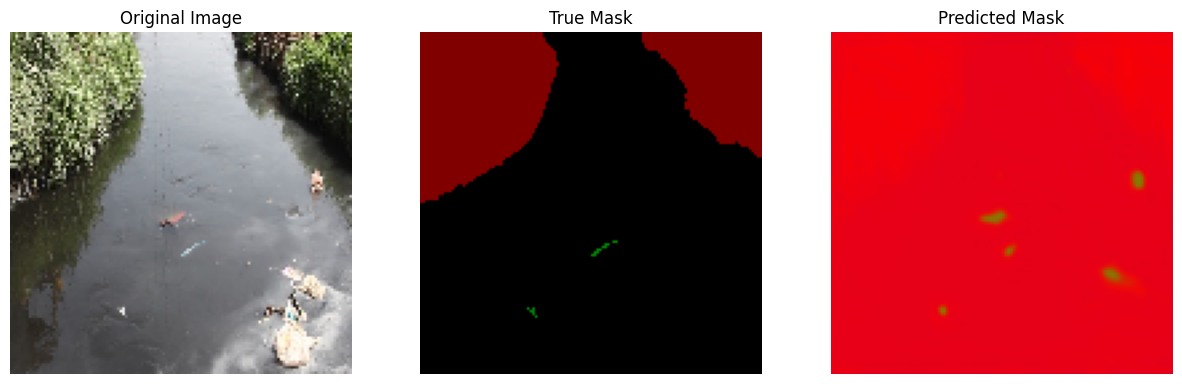

In [19]:
random_idx = random.randint(0, len(x_val) - 1)

image = x_val[random_idx]
true_mask = y_val[random_idx]

predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Expanding dimensions for batch size

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(true_mask.squeeze(), cmap='gray')  # Squeeze mask to remove unnecessary dimension
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask.squeeze(), cmap='gray')  # Squeeze predicted mask
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


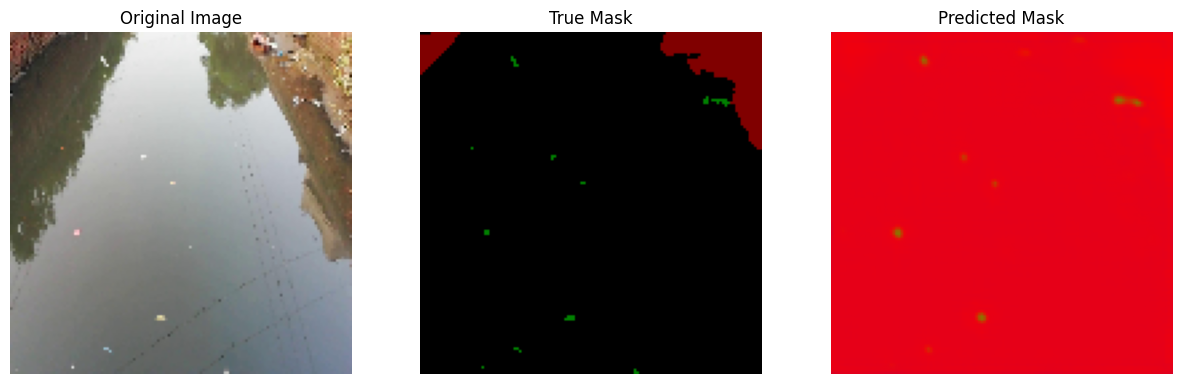

In [20]:
random_idx = random.randint(0, len(x_val) - 1)

image = x_val[random_idx]
true_mask = y_val[random_idx]

predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Expanding dimensions for batch size

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(true_mask.squeeze(), cmap='gray')  # Squeeze mask to remove unnecessary dimension
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask.squeeze(), cmap='gray')  # Squeeze predicted mask
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.show()

# Results

As we can see that reducing the model size has still yeilded a good result in the result of our image segmentation.